# Community functions 

In [1]:
# Community simulator package
from IPython.display import Image
from community_simulator import *
from community_simulator.usertools import *
from community_simulator.visualization import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf as bpdf
import numpy as np
import scipy as sp
colors = sns.color_palette()
%matplotlib inline

# Community selection package
from community_selection import *
from community_selection.A_experiment_functions import *
from community_selection.B_community_phenotypes import *
from community_selection.C_selection_algorithms import *
from community_selection.D_migration_algorithms import *

In [2]:
make_algorithm_library()

,AlgorithmType,AlgorithmName
0,community_phenotype,f1_additive
1,community_phenotype,f2_interaction
2,community_phenotype,f3_additive_binary
3,community_phenotype,f4_interaction_binary
4,community_phenotype,f5_invader_growth
5,community_phenotype,f6_resident_growth
0,selection_algorithm,no_selection
1,selection_algorithm,select_top25percent
2,selection_algorithm,select_top10percent
3,selection_algorithm,select_bottom25percent


In [22]:
# Make dynanmics by default we will use the microbial consumer resource model
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

# Global parameters
## Default parameters from community-simulator
## !!!Don't touch this dictionary!!!
assumptions = a_default.copy() # Start with default parameters
a_default = {'sampling':'Binary', #{'Gaussian','Binary','Gamma'} specifies choice of sampling algorithm
            'SA': 60*np.ones(3), #Number of species in each specialist family (here, 3 families of 60 species)
            'MA': 30*np.ones(3), #Number of resources in each class 
            'Sgen': 30, #Number of generalist species (unbiased sampling over alll resource classes)
            'muc': 10, #Mean sum of consumption rates (used in all models)
            'sigc': 3, #Standard deviation of sum of consumption rates for Gaussian and Gamma models
            'q': 0.0, #Preference strength of specialist families (0 for generalist and 1 for specialist)
            'c0':0.0, #Sum of background consumption rates in binary model
            'c1':1., #Specific consumption rate in binary model
            'l':0.8, #Leakage fraction
            'fs':0.45, #Fraction of secretion flux with same resource type
            'fw':0.45, #Fraction of secretion flux to 'waste' resource
            'sparsity':0.2, #Effective sparsity of metabolic matrix (between 0 and 1)
            'n_wells':10, #Number of independent wells
            'S':100, #Number of species per well (randomly sampled from the pool of size Stot = sum(SA) + Sgen)
            'food':0, #index of food source (when a single resource is supplied externally)
            'R0_food':1000, #unperturbed fixed point for supplied food
            'regulation':'independent', #metabolic regulation (see dRdt)
            'response':'type I', #functional response (see dRdt)
            'supply':'off' #resource supply (see dRdt)
            }

## Update parameters for community-selection
assumptions.update({
    'SA': 60*np.ones(3), #Number of species in each specialist family (here, 3 families of 60 species)
    'MA': 30*np.ones(3), #Number of resources in each class 
    'Sgen': 30, #Number of generalist species (unbiased sampling over alll resource classes)
    "n_wells": 24,
    "c1": 1, #Rescale uptake rate part 1. This is needed to avoid numerical errors that slow down the simulations
    "muc": 10, # Rescale uptake part 2
    "m": 0, # Mortality
    "scale": 10**6,  #scale is a conversion factor specifying the number of individual microbial cells present when N = 1.
    "sigma" : 1, # Standard deviation for drawing specifc speices/interaction function
    "alpha": 1, # Scaling factor between species- and interaction-specific function variances
    "response": "type III",
    "sigma_max": 100,  # The maximal resource  
    'R0_food': 1000, #unperturbed fixed point for supplied food
    # The parameters below will be passed to params_simulation
    "n_propagation": 8, # Length of propagation, or hours within a growth cycle
    "n_transfer": 40, # Number of total transfer, or number of passage
    "n_transfer_selection": 20, # Number of transfer implementing seleciton regimes 
    "dilution": 1/125, # Dilution factor at every transfer
    "n_inoc": 128,  #Number of cells sampled from the regional species at start
    "selected_function": "f1_additive"
})

# Prepare experiment setup in this universe
params, params_simulation = prepare_experiment(assumptions, seed = 1)



In [10]:
# Set seeds
np.random.seed(2)

# Make initial state
init_state = MakeInitialState(assumptions)

# Make plate
plate = Community(init_state, dynamics, params, scale = assumptions["scale"], parallel = True) 

# Update the community composition by sampling from the pool
print("\nGenerating initial plate")
plate.N = sample_from_pool(plate.N, scale = assumptions["scale"], inocula = params_simulation["n_inoc"], two_pools = False, initial_inocula_pool = True)


# 
plate_R = plate.R.copy()

# Total number of species in this universe
R_tot = plate_R.shape[0] 

# Make empty plate
N0 = np.zeros((plate_R.shape)) # Make empty plate

# Consumer index
resource_index = plate_R.index 

# Well index
well_names = plate_R.columns



Generating initial plate


In [19]:

assumptions["R0_food"] / int(np.sum(assumptions["MA"]))

11.11111111111111

In [23]:
data_directory = "data/typeIII-24wells-rich_medium/"
list_phenotypes = ["f1_additive"]
#list_phenotypes = ["f1_additive", "f2_interaction", "f3_additive_binary", "f4_interaction_binary"]
list_algorithms = ["simple_screening"]
#list_algorithms = ["simple_screening", "swenson2000", "direct_selection", "panke_buisse2015", "pair_top_communities", "multiple_pair_top"]


for j in range(len(list_phenotypes)):
    # Parameters for simulation
    params_simulation.update({"selected_function": list_phenotypes[j]}) # selected function

    # Make the list of algorithms
    algorithms = make_algorithms(params_simulation)
    
    # Simulation
    for i in range(len(list_algorithms)):
        simulate_community(
            assumptions = assumptions,
            params = params,
            dynamics = dynamics,
            params_simulation = params_simulation, 
            params_algorithm = algorithms[algorithms["algorithm_name"] == list_algorithms[i]], 
            write_composition = True,
            file_name = data_directory + list_algorithms[i],
            assembly_type = str(list_algorithms[i]),
        )
        


Algorithm: simple_screening


 transfer community_phenotype selection_algorithm migration_algorithm
        1         f1_additive        no_selection        no_migration
        2         f1_additive        no_selection        no_migration
        3         f1_additive        no_selection        no_migration
        4         f1_additive        no_selection        no_migration
        5         f1_additive        no_selection        no_migration
        6         f1_additive        no_selection        no_migration
        7         f1_additive        no_selection        no_migration
        8         f1_additive        no_selection        no_migration
        9         f1_additive        no_selection        no_migration
       10         f1_additive        no_selection        no_migration
       11         f1_additive        no_selection        no_migration
       12         f1_additive        no_selection        no_migration
       13         f1_additive        no_selection        no

# F1: additive function 
$f_1=\sum{\lambda_i n_i}$

In [5]:
# Parameters for simulation
params_simulation.update({"selected_function": "f1_additive"}) # selected function

# Make the list of algorithms
algorithms = make_algorithms(params_simulation)
list_algorithms = ["select_top25percent", "simple_screening"]

# Simulation
tested_algorithm = "simple_screening"
f1_ctrl = simulate_community(assumptions = assumptions, params = params, dynamics = dynamics, params_simulation = params_simulation, write_composition = False,
                             params_algorithm = algorithms[algorithms["algorithm_name"] == tested_algorithm], assembly_type = str(tested_algorithm))



Algorithm: simple_screening


 transfer community_phenotype selection_algorithm migration_algorithm
        1         f1_additive        no_selection        no_migration
        2         f1_additive        no_selection        no_migration
        3         f1_additive        no_selection        no_migration
        4         f1_additive        no_selection        no_migration
        5         f1_additive        no_selection        no_migration
        6         f1_additive        no_selection        no_migration
        7         f1_additive        no_selection        no_migration
        8         f1_additive        no_selection        no_migration
        9         f1_additive        no_selection        no_migration
       10         f1_additive        no_selection        no_migration
       11         f1_additive        no_selection        no_migration
       12         f1_additive        no_selection        no_migration
       13         f1_additive        no_selection        no

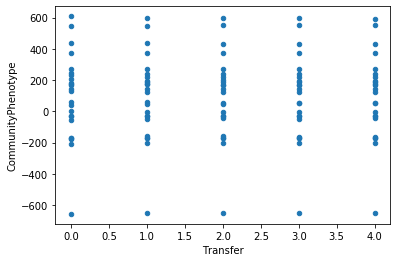

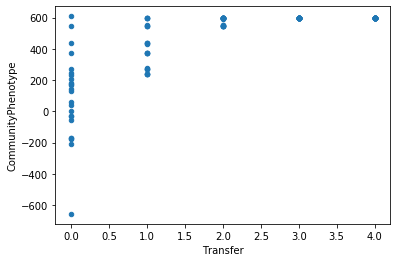

In [6]:
plot_community_function(f1_ctrl)
plot_community_function(f1_selc)

In [4]:
def select_community(params_algorithm = {"community_phenotype": "f1_community_function_additive", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"}):
    """
    Wrapper function for running control(screening) and selection given the selection algorithms and communtiy phenotype
    """
    # Control plate
    np.random.seed(2)
    # Make initial state
    init_state = MakeInitialState(assumptions)
    # Make plate
    plate = Community(init_state, dynamics, params, scale = 10**6, parallel = True) 
    setattr(plate, "species_function", species_function)
    setattr(plate, "interaction_function", interaction_function)
    # Simulation
    ctrl_plate_df, ctrl_function_df = simulate_community(plate, assumptions = assumptions, params_simulation = params_simulation, params_algorithm = {"community_phenotype": params_algorithm["community_phenotype"], "selection_algorithm": "no_selection", "migration_algorithm": params_algorithm["migration_algorithm"]}, write_composition = False)

    # Selection plate
    np.random.seed(2)
    # Make initial state
    init_state = MakeInitialState(assumptions)
    # Make plate
    plate = Community(init_state, dynamics, params, scale = 10**6, parallel = True) 
    setattr(plate, "species_function", species_function)
    setattr(plate, "interaction_function", interaction_function)
    # Simulation
    selection_plate_df, selection_function_df = simulate_community(plate, assumptions = assumptions, params_simulation = params_simulation, params_algorithm = params_algorithm, write_composition = False)

    return ctrl_function_df, selection_function_df

# F2: additive function with interaction term
$f_2=\sum{\lambda_i n_i} + \sum{\lambda_{ij} n_i n_j}$

In [13]:
f2_ctrl, f2_selc = select_community(params_algorithm = {"community_phenotype": "f2_interaction", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"})

Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done
Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done


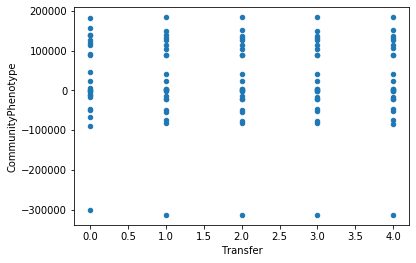

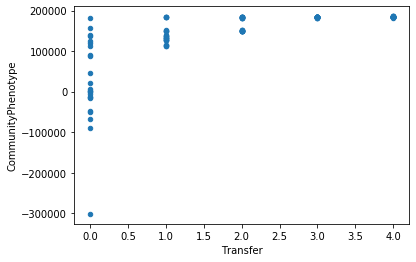

In [15]:
plot_community_function(f2_ctrl)
plot_community_function(f2_selc)

# F3: binary additive function
$f_3 = \sum{\lambda_i}$

In [16]:
f3_ctrl, f3_selc = select_community(params_algorithm = {"community_phenotype": "f3_additive_binary", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"})

Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done
Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done


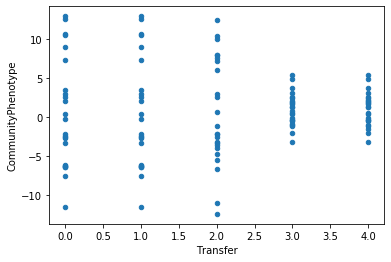

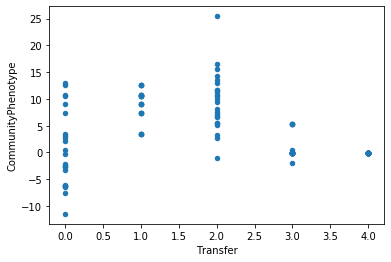

In [17]:
plot_community_function(f3_ctrl)
plot_community_function(f3_selc)

# F4: binary addtive function with interactions
$f_4 = \sum{\lambda_i} + \sum{\lambda_{ij}}$

In [18]:
f4_ctrl, f4_selc = select_community(params_algorithm = {"community_phenotype": "f4_interaction_binary", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"})

Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done
Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done


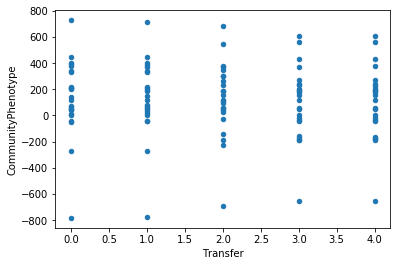

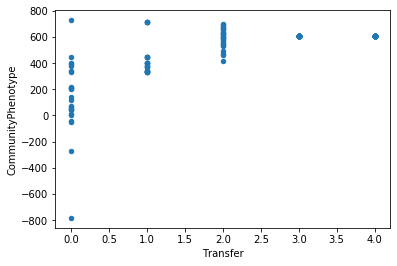

In [19]:
plot_community_function(f4_ctrl)
plot_community_function(f4_selc)

# F5: resistence
$f_5 = x_p(t)/x_p(0)$, where $x_p(t)$ is the invasive pathgen biomass after growing with the community, $x_p(0)$ is the invasive pathogen biomass at the time of invasion 

In [20]:
f5_ctrl, f5_selc = select_community(params_algorithm = {"community_phenotype": "f5_invasion_growth", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"})

Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done
Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done


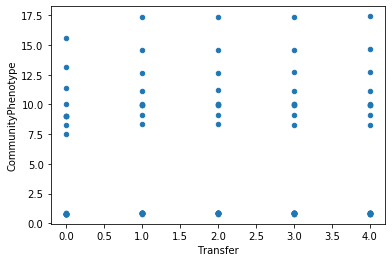

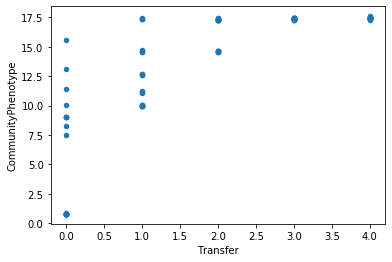

In [21]:
plot_community_function(f5_ctrl)
plot_community_function(f5_selc)



# F6: resident growth
$f_6 = x_p(t)/x_p^*(t)$, where $x_p(t)$ is the pathogen biomass grown with the coalscenced community, $x_p^*(t)$ is the pathogen biomass grown with its residential community

In [5]:
f6_ctrl, f6_selc = select_community(params_algorithm = {"community_phenotype": "f6_resident_growth", "selection_algorithm": "select_top25percent", "migration_algorithm": "no_migration"})

Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done
Transfer 1 done
Transfer 2 done
Transfer 3 done
Transfer 4 done
Transfer 5 done


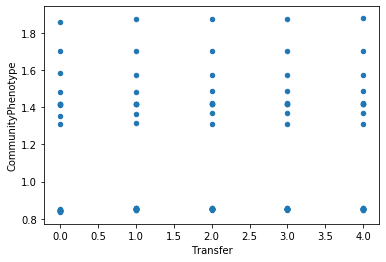

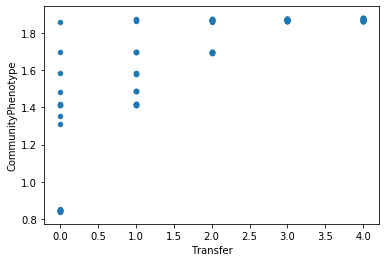

In [6]:
plot_community_function(f6_ctrl)
plot_community_function(f6_selc)

# Output the result


In [3]:
def concat_result(f_ctrl, f_selc, species_pool_seed, phenotype_algorithm = "f6_resident_growth", selection_algorithm = "select_best_n"):
    """
    Concatenate the result data.frame from control (no-selection) and selection experiment
    """
    # 
    f_ctrl["Experiment"] = "control"
    f_selc["Experiment"] = "selection"
    
    #
    f_result = pd.concat([f_ctrl, f_selc])
    f_result["SelectionAlgorithmName"] = selection_algorithm
    f_result["CommunityPhenotypeName"] = phenotype_algorithm
    f_result["SpeciesPool"] = species_pool_seed

    # Write the result
    f_result.to_csv("data/" + selection_algorithm + "-" + phenotype_algorithm + "-pool" + str(species_pool_seed) + ".txt", index = False)


,AlgorithmType,AlgorithmName
0,community_phenotype,f1_community_function_additive
1,community_phenotype,f2_community_function_interaction
2,community_phenotype,f3_community_function_additive_binary
3,community_phenotype,f4_community_function_interaction_binary
4,community_phenotype,f5_invasion_growth
5,community_phenotype,f6_resident_growth
0,selection_algorithm,no_selection
1,selection_algorithm,select_top25percent
2,selection_algorithm,select_bottom25percent
0,migration_algorithm,no_migration


In [62]:
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f1_community_function_additive", selection_algorithm = "select_top25percent")
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f2_community_function_interaction", selection_algorithm = "select_top25percent")
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f3_community_function_additive_binary", selection_algorithm = "select_top25percent")
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f4_community_function_interaction_binary", selection_algorithm = "select_top25percent")
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f5_invasion_growth", selection_algorithm = "select_top25percent")
concat_result(f_ctrl, f_selc, 1,  phenotype_algorithm = "f6_resident_growth", selection_algorithm = "select_top25percent")
